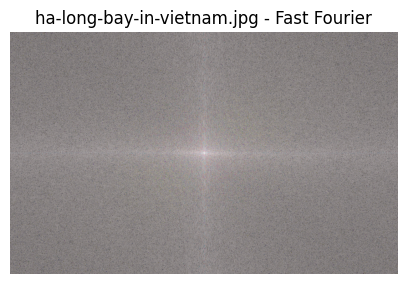

C:\Users\Admin\AppData\Local\Temp\ipykernel_42068\3650727570.py:47: RuntimeWarning: divide by zero encountered in divide
  H = 1 / (1 + (D0/D)**(2*n))


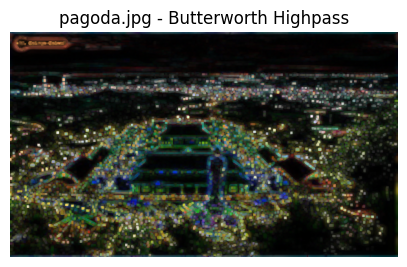

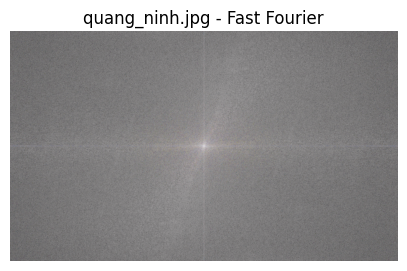

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

def get_image_files(folder):
    exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(exts)]

def show_img(title, img):
    plt.figure(figsize=(5,5))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def fast_fourier(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
    return np.uint8(255 * magnitude_spectrum / np.max(magnitude_spectrum))

def butterworth_lowpass(img, D0=30, n=2):
    rows, cols = img.shape
    crow, ccol = rows//2, cols//2
    u = np.arange(rows)
    v = np.arange(cols)
    U, V = np.meshgrid(u, v, indexing='ij')
    D = np.sqrt((U-crow)**2 + (V-ccol)**2)
    H = 1 / (1 + (D/D0)**(2*n))
    F = np.fft.fft2(img)
    Fshift = np.fft.fftshift(F)
    G = H * Fshift
    img_back = np.fft.ifft2(np.fft.ifftshift(G))
    img_back = np.abs(img_back)
    img_back = np.uint8(255 * img_back / np.max(img_back))
    return img_back

def butterworth_highpass(img, D0=30, n=2):
    rows, cols = img.shape
    crow, ccol = rows//2, cols//2
    u = np.arange(rows)
    v = np.arange(cols)
    U, V = np.meshgrid(u, v, indexing='ij')
    D = np.sqrt((U-crow)**2 + (V-ccol)**2)
    H = 1 / (1 + (D0/D)**(2*n))
    H[D==0] = 0
    F = np.fft.fft2(img)
    Fshift = np.fft.fftshift(F)
    G = H * Fshift
    img_back = np.fft.ifft2(np.fft.ifftshift(G))
    img_back = np.abs(img_back)
    img_back = np.uint8(255 * img_back / np.max(img_back))
    return img_back

def min_filter(img, ksize=3):
    return cv2.erode(img, np.ones((ksize, ksize), np.uint8))

def max_filter(img, ksize=3):
    return cv2.dilate(img, np.ones((ksize, ksize), np.uint8))

transformations = [
    ("Fast Fourier", fast_fourier),
    ("Butterworth Lowpass", butterworth_lowpass),
    ("Butterworth Highpass", butterworth_highpass)
]

folder = 'exercise'
output_folder = 'exercise_output_bai4'
os.makedirs(output_folder, exist_ok=True)
image_files = get_image_files(folder)

for img_path in image_files:
    img = cv2.imread(img_path)
    if img is None:
        print(f"Không thể đọc ảnh: {img_path}")
        continue

    trans_name, trans_func = random.choice(transformations)
    channels = cv2.split(img)
    new_channels = []

    for ch in channels:
        ch_trans = trans_func(ch)
        # Nếu là Butterworth Lowpass, áp dụng Min Filter
        if trans_name == "Butterworth Lowpass":
            ch_trans = min_filter(ch_trans)
        # Nếu là Butterworth Highpass, áp dụng Max Filter
        if trans_name == "Butterworth Highpass":
            ch_trans = max_filter(ch_trans)
        new_channels.append(ch_trans)

    img_trans = cv2.merge(new_channels)
    out_path = os.path.join(
        output_folder,
        f"{os.path.splitext(os.path.basename(img_path))[0]}_{trans_name.replace(' ', '_')}.jpg"
    )
    cv2.imwrite(out_path, img_trans)
    show_img(f"{os.path.basename(img_path)} - {trans_name}", img_trans)